alpha: 0.18814639333900451 rho: 0.18426792551611515 nu: 3.449604073273506


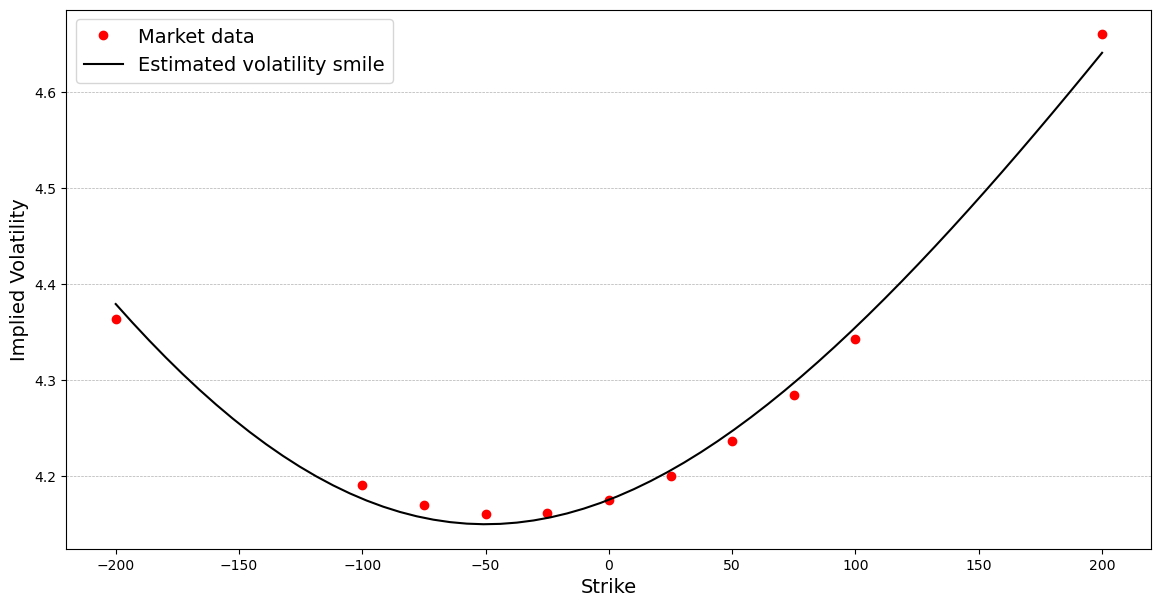

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho):
    '''Given a list of strike prices and SABR parameters, returns what the SABR
    model predicts the market volatility to be. Calculated from equations (2.17) 
    and (2.18) in Hagan, Patrick S., Deep Kumar, Andrew S. Lesniewski, and 
    Diana E. Woodward "Managing smile risk." The Best of Wilmott 1 (2002): 249-296.
    '''
    output = np.zeros(len(K))
    
    for i in range(0,len(K)):
        if K[i] == f: #ATM equation in Managing smile risk
            part_1 = (1.0 - beta)**2.0*alpha**2.0/(24.0*f**(2.0 - 2.0*beta))
            part_2 = rho*beta*alpha*nu/(4.0*f**(1.0 - beta))
            part_3 = (2.0 - 3.0*rho**2)*nu**2.0/24.0
            
            output[i] = (alpha/f**(1 - beta))*(1 + (part_1 + part_2 + part_3)*t_exp )
        
        else:
            logfK = np.log(f/K[i])
            fkbpow = (f*K[i])**((1.0 - beta)/2.0)
            z = nu*fkbpow*logfK/alpha
            xz = np.log((np.sqrt(1.0 - 2.0*rho*z + z**2.0 ) + z - rho)/(1.0-rho))
            
            part_1 = ((1.0-beta)**2.0)*(alpha**2.0)/(24.0*fkbpow**2.0)
            part_2 = (rho*beta*nu*alpha)/(4.0*fkbpow)
            part_3 = (2.0-3.0*rho**2)*nu**2.0/24.0
            part_4 = ((1.0-beta)**2)*(logfK**2)/24.0
            part_5 = ((1.0-beta)**4)*(logfK**4)/1920.0
            
            output[i] = (alpha*z*(1 + (part_1 + part_2 + part_3)*t_exp ))/(fkbpow*xz*(1 + part_4 + part_5 ))
            
    return output

def atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho):
    '''Returns alpha given the forward price, the at-the-money volatility, the 
    time to exirpy (t_exp) and the other parameters in the SABR model by 
    solving a cubic equation for alpha, equation (2.18) in Hagan, Patrick S., 
    Deep Kumar, Andrew S. Lesniewski, and Diana E. Woodward. 
    "Managing smile risk." The Best of Wilmott 1 (2002): 249-296. 
    '''
    #The coeffceints of the polynomial we find the roots of
    p_3 = -sigma_atm
    p_2 =  (1 + (2-3*rho**2)*nu**2*t_exp/24)/f**(1.-beta)
    p_1 = rho*beta*nu*t_exp/(4*f**(2-2*beta))
    p_0 = (1-beta)**2*t_exp/(24*f**(3-3*beta))
    coeffs = [p_0,p_1,p_2,p_3]
    
    r = np.roots(coeffs)    #find the roots of the cubic equation
    
    return r[(r.imag==0) & (r.real>=0)].real.min() 

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols,guess):
    ''' Returns the parameters alpha, nu and rho given a parameter beta, 
    forward price, a list of market volatilities and corrsponding strike 
    spread. Instead of doing a regression in all three parameters, this method 
    calculates alpha when needed from nu and rho. Hence a regression is done 
    in only two variables.
    '''
    def func_to_optimize(K,nu,rho):
        alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
        return  SABR_market_vol(K,f,t_exp,alpha,beta,nu,rho)
     
    popt, pcov = curve_fit(func_to_optimize, strikes, vols, p0 = (guess[1],guess[2]), maxfev=10000)
      
    nu = popt[0]
    rho = popt[1]
    alpha = atm_sigma_to_alpha(f,t_exp,sigma_atm,beta,nu,rho)
    
    return [alpha, nu, rho]
        


#10Y30Y 2024
beta = 0.5
sigmas = np.array([0.4364, 0.4191, 0.41706,0.41605, 0.41619,0.41757,0.42003,0.42370,0.42847,0.43428,0.46603])
sigmas = sigmas*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 30
atm_sigma = 0.41757*10
#atm_sigma =atm_sigma *10
f = 0.23401
#f = f*10
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y30Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y30Y_est.png")  
plt.show()
plt.close()

alpha: 0.1939409562543678 rho: 0.20480359600907852 nu: 3.5607729718760908


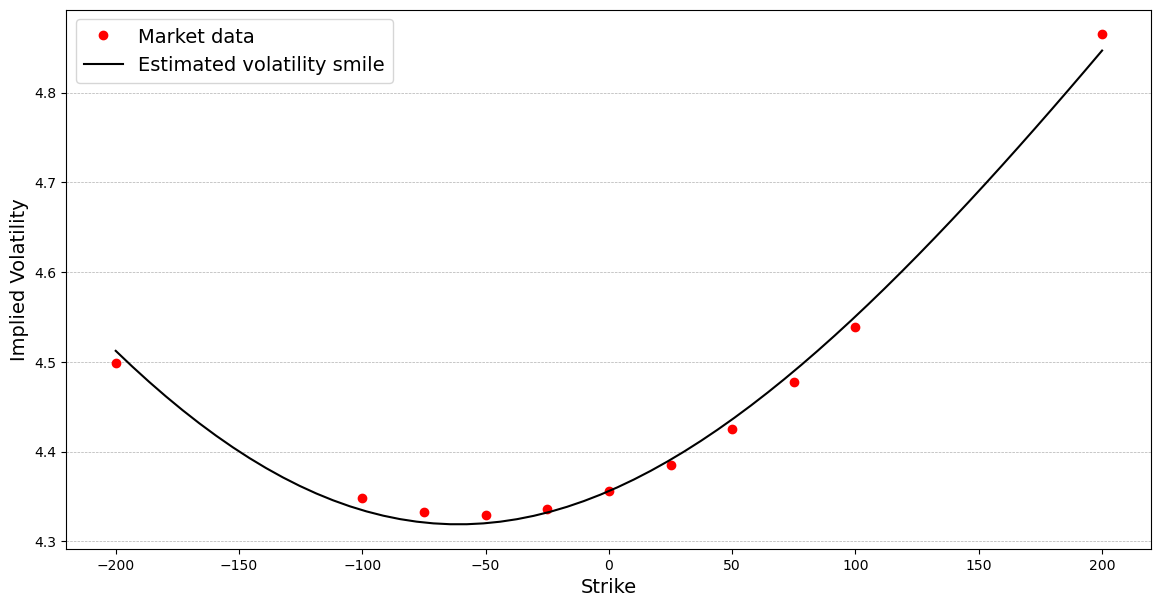

In [2]:
#10Y20Y 2024
beta = 0.5
sigmas1 = np.array([0.44983,	0.43478,	0.43329,	0.43288,	0.43360,
                   	0.43559,	0.43846,	0.44256,	0.44772,	0.45385,	0.48650])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 20
atm_sigma = 0.43559*10
f = 0.251744
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas1, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas1, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y20Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y20Y_est.png")  
plt.show()
plt.close()

alpha: 0.20071386072626338 rho: 0.22018691193142007 nu: 3.6347995205993735


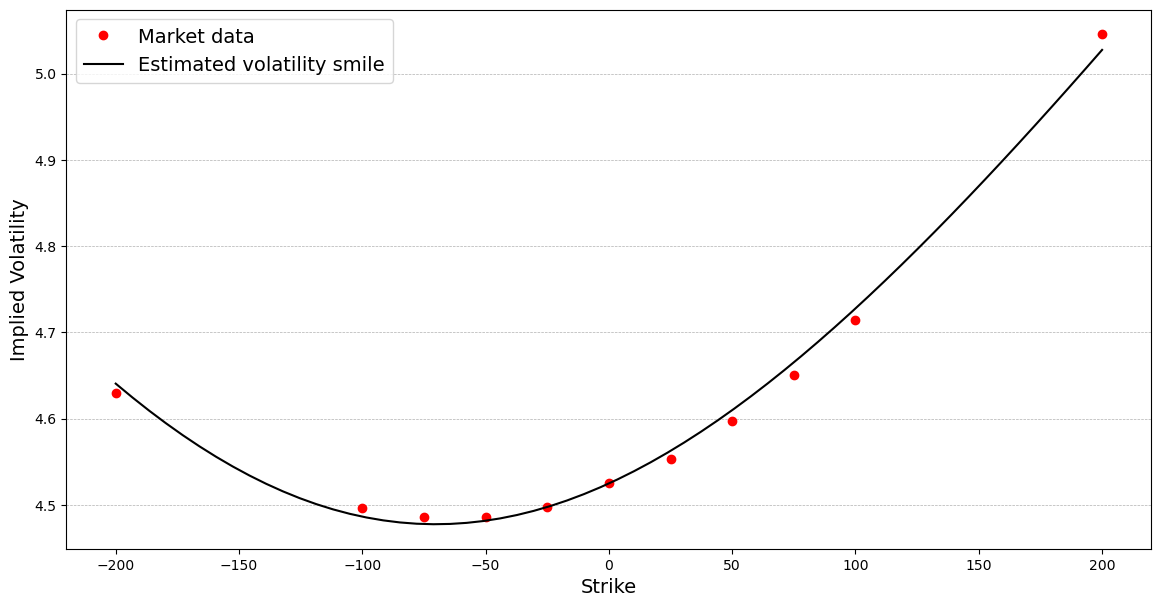

In [3]:
#10Y15Y 2024
beta = 0.5
sigmas2 = np.array([0.46292,	0.44963,	0.44859,	0.44862,	0.44974,
                    0.45247,	0.45530,	0.45970,	0.46509,	0.47143,	0.50457])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 15
atm_sigma = 0.45247*10
f = 0.265454
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas2, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas2, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y15Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y15Y_est.png")  
plt.show()
plt.close()

alpha: 0.2129167335998786 rho: 0.2461600298929721 nu: 3.4445981347975194


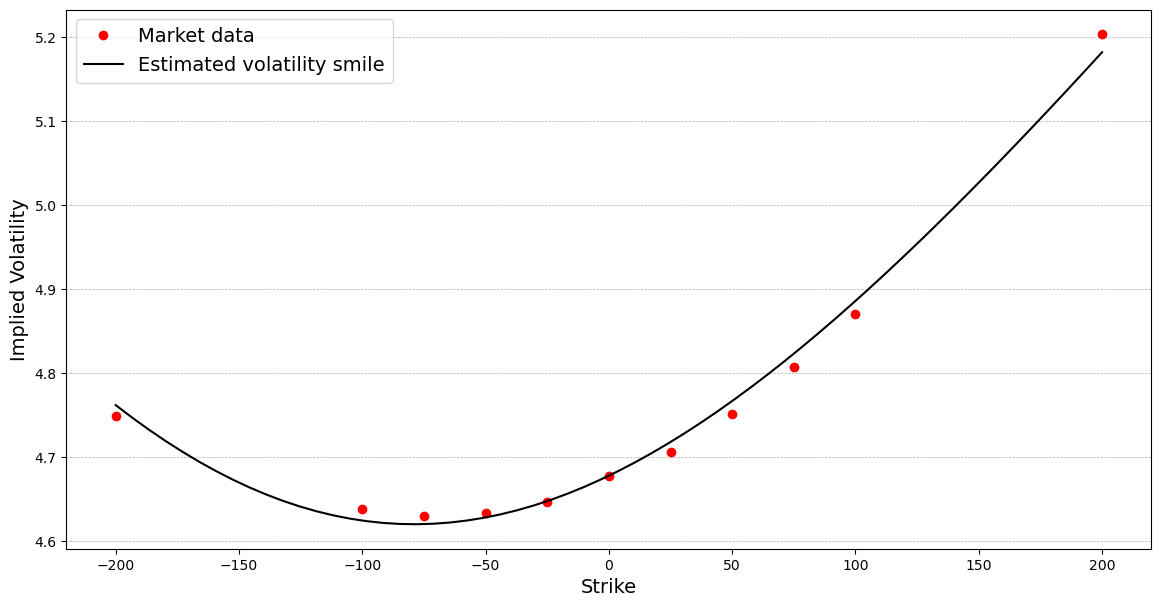

In [4]:
#10Y12Y 2024
beta = 0.5
sigmas3 = np.array([0.47487,	0.46379,	0.46305,	0.46334,	0.46470,
                    0.46781,	0.47064,	0.47517,	0.48068,	0.48709,	0.52033])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 12
atm_sigma = 0.46781*10
f = 0.2276305
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas3, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas3, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y12Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y12Y_est.png")  
plt.show()
plt.close()

alpha: 0.21300923867325772 rho: 0.23688314293263885 nu: 3.732023654084199


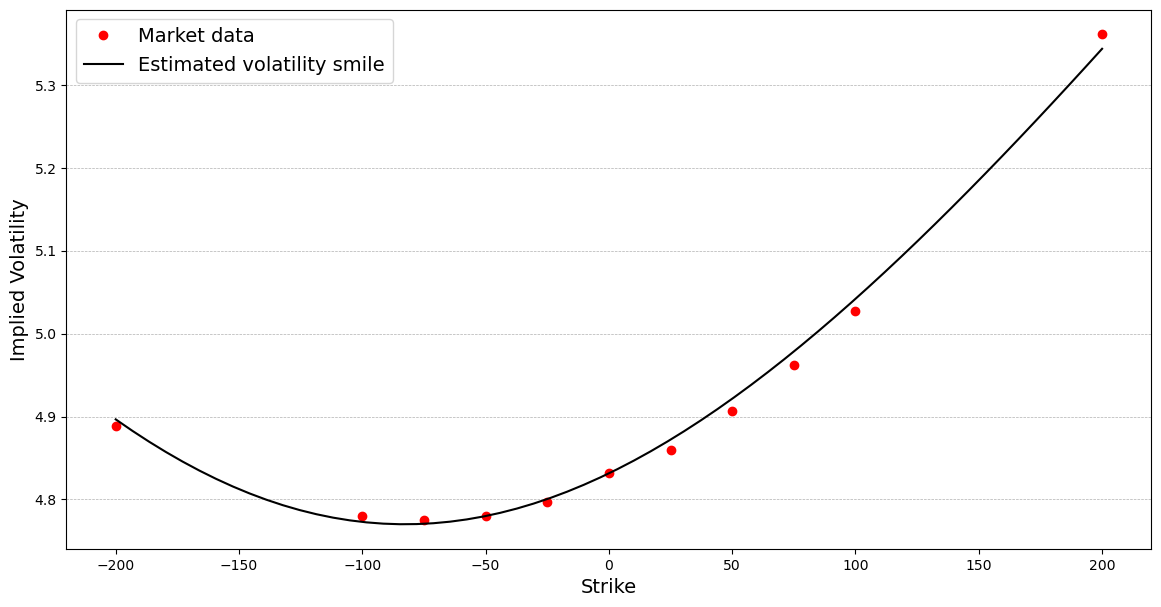

In [5]:
#10Y10Y 2024
beta = 0.5
sigmas4 = np.array([0.48882,	0.47796,	0.47750,	0.47806,	0.47966,
                    0.48315,	0.48598,	0.49065,	0.49626,	0.50275,	0.53610])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 10
atm_sigma = 0.48315*10
f = 0.284018
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas4, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas4, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y10Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y10Y_est.png")  
plt.show()
plt.close()

alpha: 0.2278292540812213 rho: 0.27623609894054385 nu: 3.7246411409645277


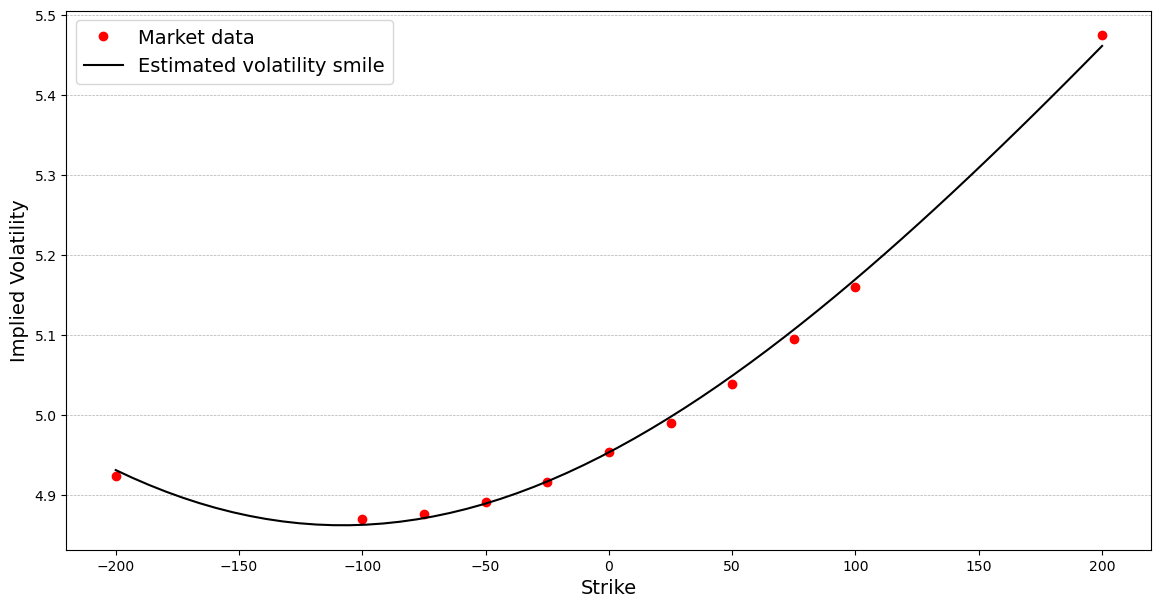

In [6]:
#10Y7Y 2024
beta = 0.5
sigmas5 = np.array([0.49234,	0.48694,	0.48762,	0.48916,	0.49157,
                    0.49531,	0.49896,	0.50388,	0.50955,	0.51594,	0.54749])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 7
atm_sigma = 0.49531*10
f = 0.294395
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas5, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas5, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y7Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y7Y_est.png")  
plt.show()
plt.close()

alpha: 0.2394103315311335 rho: 0.30305890963152116 nu: 3.7173093184894355


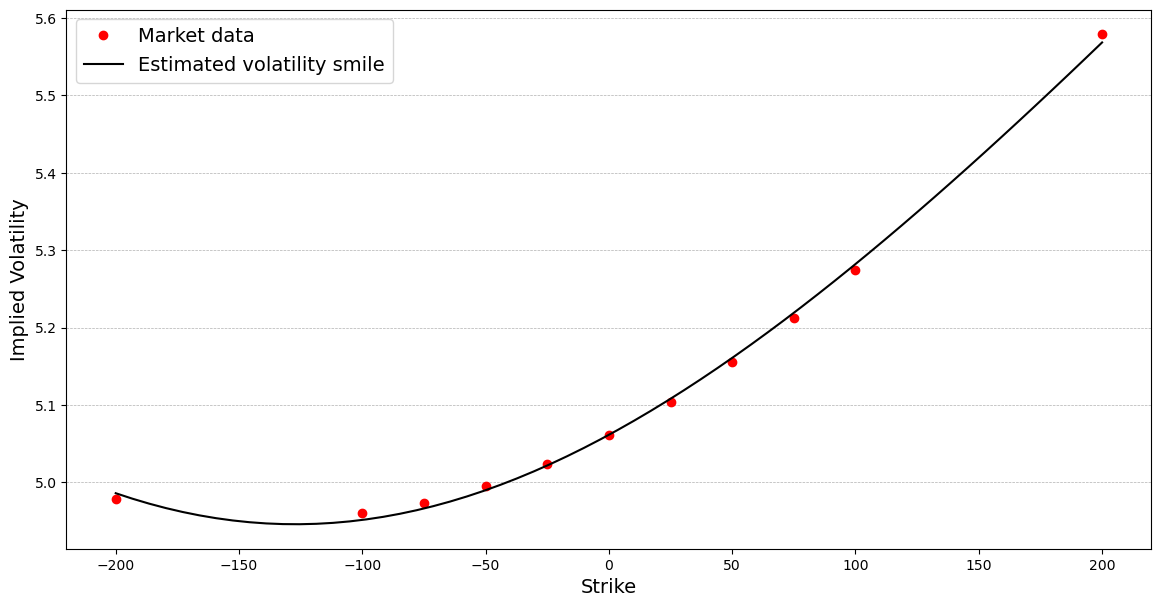

In [7]:
#10Y5Y 2024
beta = 0.5
sigmas6 = np.array([0.49781,	0.49597,	0.49735,	0.49950,	0.50241,
                    0.50614,	0.51043,	0.51549,	0.52119,	0.52750,	0.55792])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 5
atm_sigma = 0.50614*10
f = 0.299258
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas6, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas6, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y5Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y5Y_est.png")  
plt.show()
plt.close()

alpha: 0.2460172816473431 rho: 0.3367544456876326 nu: 3.7752894249279287


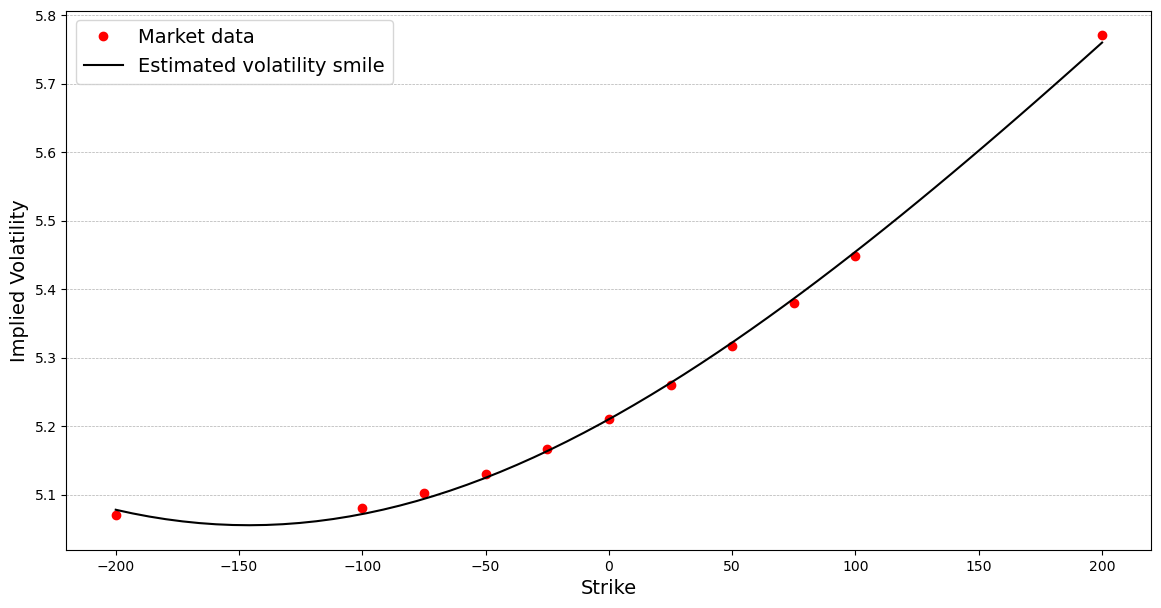

In [8]:
#10Y3Y 2024
beta = 0.5
sigmas7 = np.array([0.50699,	0.50806,	0.51017,	0.51304,	0.51665,
                    0.52101,	0.52599,	0.53166,	0.53795,	0.54480,	0.57709])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 3
atm_sigma = 0.52101*10
f = 0.299622
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas7, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas7, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y3Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y3Y_est.png")  
plt.show()
plt.close()

alpha: 0.25161383412727184 rho: 0.35466229466629196 nu: 3.7993246390313375


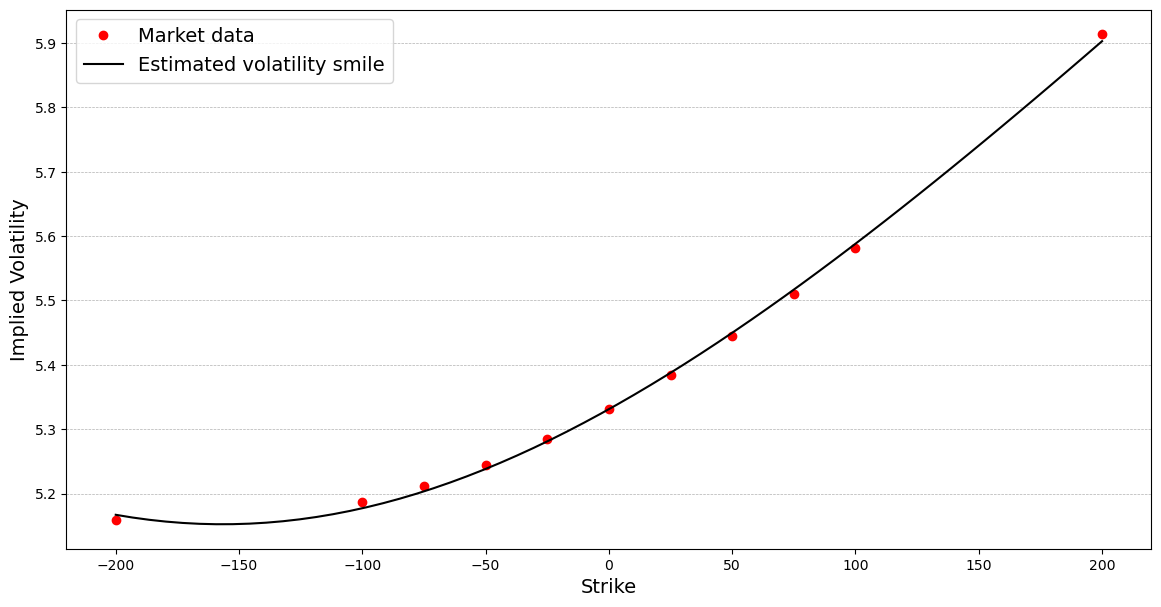

In [9]:
#10Y2Y 2024
beta = 0.5
sigmas8 = np.array([0.51588,	0.51864,	0.52116,	0.52442,	0.52841,
                    0.53311,	0.53845,	0.54444,	0.55102,	0.55815,	0.59138])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 2
atm_sigma = 0.53311*10
f = 0.297602
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas8, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas8, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y2Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y2Y_est.png")  
plt.show()
plt.close()

alpha: 0.25267858450442904 rho: 0.37117618959412424 nu: 3.8123060412173984


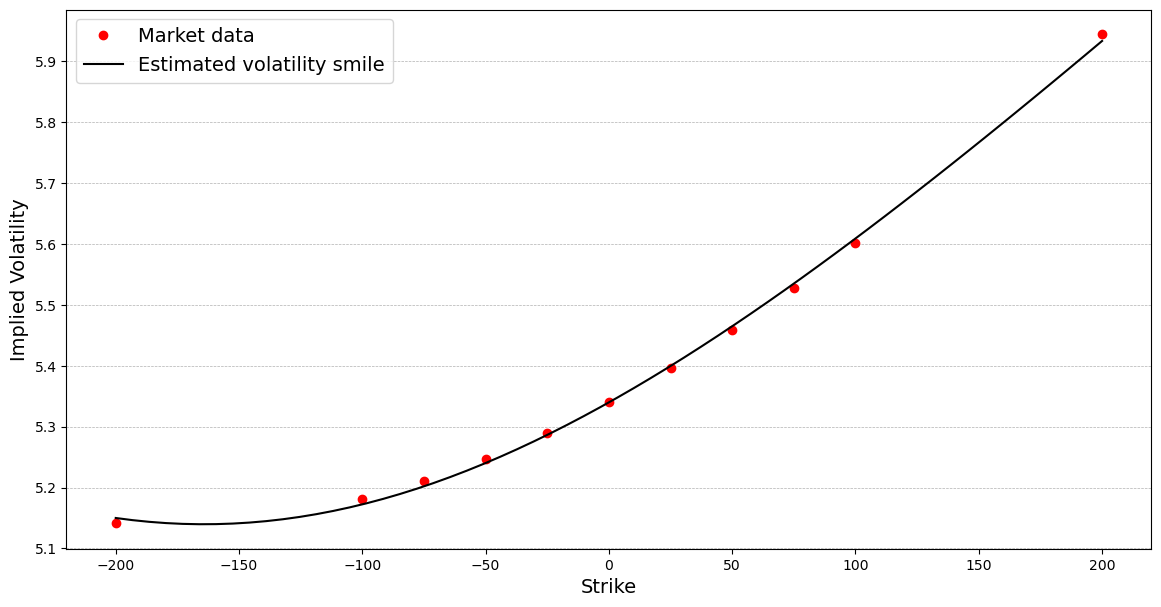

In [10]:
#10Y1Y 2024
beta = 0.5
sigmas9 = np.array([0.51416,	0.51819,	0.52105,	0.52465,	0.52898,
                    0.53399,	0.53966,	0.54596,	0.55283,	0.56025,	0.59448])*10
strikes_in_bps = np.array([-200,-100,-75,-50,-25,0,25,50,75,100,200])
t_exp = 10
tenor = 1
atm_sigma = 0.53399*10
f = 0.293838
guess = [0.01, 10,-0.5]
strikes = f + strikes_in_bps*0.0001
#Calling the SABR_calibration function defined below to return the parameters.
alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas9, guess)
    
print("alpha:",alpha,"rho:",rho, "nu:", nu)
Ks_in_bps = np.linspace(-200,200,60)
Ks = f + Ks_in_bps*0.0001
vols_from_Ks = SABR_market_vol(Ks,f,t_exp,alpha,beta,nu,rho)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(strikes_in_bps, sigmas9, 'o', color = 'red', label = 'Market data')
plt.plot(Ks_in_bps,vols_from_Ks, color = 'black', label= 'Estimated volatility smile')
plt.xlabel("Strike",fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)
#plt.title("10Y1Y EUR Swaption Implied Volatility", fontsize=18)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.savefig("/Users/nannaingemannohrt/Desktop/master_thesis/main/plots/10Y1Y_est.png")  
plt.show()
plt.close()